In [1]:
import torch
import numpy as np
import os
import matplotlib.pyplot as plt

from transformers import GPT2Tokenizer
from src.model import GPT


tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

In [2]:
model = GPT.from_pretrained("gpt2").to("cuda")

In [22]:
def create_random_repeated_seq(length=10, repeat=3):
    single = np.random.randint(0, 50000, length)
    seq = np.concatenate([single for _ in range(repeat)])
    seq = torch.tensor(seq).unsqueeze(0).to("cuda")
    return seq


def get_multiple_hiddens(seq):
    h = []
    with torch.no_grad():
        t = model.transformer.wte(seq)
        pos = torch.arange(0, seq.size(1), dtype=torch.long, device="cuda").unsqueeze(0)
        p = model.transformer.wpe(pos)
        x = model.transformer.drop(t + p)

        for i, block in enumerate(model.transformer.h):
            # x = x + self.attn(self.ln_1(x))
            # x = x + self.mlp(self.ln_2(x))

            x0 = block.ln_1(x)  # (d, ) x (d, n_vocb) -> tokens with max logprob
            x1 = block.attn(x0)
            x2 = x + x1
            x3 = block.ln_2(x2)
            x4 = block.mlp(x3)
            x5 = x2 + x4

            resids = [[xx.numpy(force=True) for xx in [x0, x1, x2, x3, x4, x5]]]

            h += resids

            x = x5

    return np.array(h)


seq = np.array([create_random_repeated_seq()[0].cpu() for _ in range(64)])
seq = torch.tensor(seq).to("cuda")
# model.generate_hiddens_all(seq).shape
get_multiple_hiddens(seq).shape

(12, 6, 64, 30, 768)

In [3]:
def create_random_repeated_seq(length=10, repeat=3):
    single = np.random.randint(0, 50000, length)
    seq = np.concatenate([single for _ in range(repeat)])
    seq = torch.tensor(seq).unsqueeze(0).to("cuda")
    return seq


def unembd(vector, topk=5):
    final_ln_layer = model.lm_head
    if not isinstance(vector, torch.Tensor):
        vector = torch.tensor(vector).to("cuda")
    scores = final_ln_layer(vector).numpy(force=True)

    if topk == "max":
        return np.argsort(scores)[::-1]
    return np.argsort(scores)[::-1][:topk]


def untoken(tokens):
    if isinstance(tokens, torch.Tensor) and len(tokens.size()) > 1:
        tokens = tokens[0]
    return [tokenizer.decode(t) for t in tokens]


def largest_indices(v, topk=5):
    return np.argsort(v)[::-1][:topk]


def get_multiple_hiddens(seq):
    h = []
    with torch.no_grad():
        t = model.transformer.wte(seq)
        pos = torch.arange(0, seq.size(1), dtype=torch.long, device="cuda").unsqueeze(0)
        p = model.transformer.wpe(pos)
        x = model.transformer.drop(t + p)

        for i, block in enumerate(model.transformer.h):
            # x = x + self.attn(self.ln_1(x))
            # x = x + self.mlp(self.ln_2(x))

            x0 = block.ln_1(x)  # (d, ) x (d, n_vocb) -> tokens with max logprob
            x1 = block.attn(x0)
            x2 = x + x1
            x3 = block.ln_2(x2)
            x4 = block.mlp(x3)
            x5 = x2 + x4

            h += [np.vstack([xx.numpy(force=True) for xx in [x0, x1, x2, x3, x4, x5]])]

            x = x5

    return np.array(h)


def find_pos(tokens, t):
    if isinstance(tokens, torch.Tensor):
        tokens = tokens[0].numpy(force=True)
    if t in list(tokens):
        return list(tokens).index(t)
    return -1


def get_hiddens_alphas_vectors(seq):
    alphas = []
    vectors = []
    hiddens = []
    with torch.no_grad():
        t = model.transformer.wte(seq)
        pos = torch.arange(0, seq.size(1), dtype=torch.long, device="cuda").unsqueeze(0)
        p = model.transformer.wpe(pos)
        x = model.transformer.drop(t + p)

        for i, block in enumerate(model.transformer.h):
            x = x + block.attn(block.ln_1(x))
            tmp = block.ln_2(x)
            mlp = block.mlp
            alpha = mlp.gelu(mlp.c_fc(tmp))
            r = mlp.c_proj(alpha)
            r = mlp.dropout(r)

            alphas.append(alpha.numpy(force=True)[0])

            x += r

            v = mlp.c_proj.weight.T
            if i < 11:
                h = model.transformer.h[i + 1].ln_1(x)
                v = model.transformer.h[i + 1].ln_1(v)
            else:
                h = model.transformer.ln_f(x)
                v = model.transformer.ln_f(v)

            hiddens.append(h.numpy(force=True)[0])
            vectors.append(v.numpy(force=True))

    return np.array(hiddens), np.array(alphas), np.array(vectors)

In [4]:
def calculate_pos(tokens):
    indices = []
    hiddens = get_multiple_hiddens(tokens)
    for layer in range(5, 12):
        for i, x in enumerate(hiddens[layer, :, -1]):
            t = unembd(x, topk=100)
            to_find = tokens[0, 0]
            p = find_pos(t, to_find)
            if p < 0:
                p = 100
            indices.append(p)
    return indices


pall = []
for _ in range(100):
    tokens = create_random_repeated_seq()
    pos = calculate_pos(tokens)
    pall.append(pos)

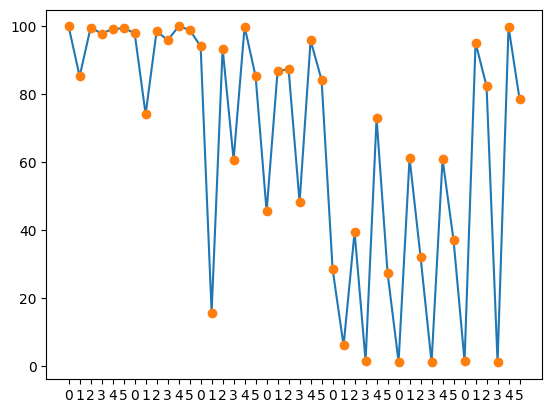

In [5]:
pall = np.array(pall)
plt.plot(pall.mean(0))
plt.xticks(np.arange(7 * 6), np.concatenate([np.arange(6) for _ in range(7)]))
plt.plot(pall.mean(0), "o")

In [8]:
tokens = create_random_repeated_seq()
print(untoken(tokens)[:10])

hiddens = get_multiple_hiddens(tokens)
for layer in range(5, 12):
    print("Layer", layer)
    for i, x in enumerate(hiddens[layer, :, -1]):
        print(f"Hidden {i}", untoken(unembd(x, topk=10)))

[' pedals', ' insistence', ' geographical', ' Hist', 'Thread', ' beans', 'VERT', ' Stamford', ' exceeded', ' surrog']
Layer 5
Hidden 0 [' (', ' for', '-', ' a', '.', ' and', ' one', ' in', ' the', ',']
Hidden 1 [',', '.', ' and', "'s", '-', '\n', ' to', '/', ' (', ' "']
Hidden 2 ['-', ',', ' and', '.', ' (', ' a', ' the', ' for', '\n', ' in']
Hidden 3 [' (', '.', ' and', ' for', '-', ',', '\n', '/', ' to', ' parts']
Hidden 4 ['anship', 'agic', 'igious', 'tesy', 'due', 'ographed', 'liga', '��', 'igrate', 'asus']
Hidden 5 ['-', ',', ' and', '.', ' (', ' a', ' for', ' the', ' in', '\n']
Layer 6
Hidden 0 ['.', '-', ' for', ' (', ' and', ',', ' parts', "'s", 'ra', ' a']
Hidden 1 ['-', "'s", ' Jr', '_', ',', 'gger', 'onz', ' and', '/', ' &']
Hidden 2 ['-', ',', ' and', '.', ' (', "'s", ' for', ' a', '\n', ' the']
Hidden 3 ['-', '.', ' and', ',', ' (', "'s", ' for', '/', '\n', '_']
Hidden 4 ['pload', ' Honda', ' I', 'minster', ' Due', ' Norton', ' transcription', ' Gibson', ' [', ' Nib']
Hidd

In [7]:
tokens = create_random_repeated_seq()
print(untoken(tokens)[:10])

hiddens, alphas, vectors = get_hiddens_alphas_vectors(tokens)
for layer in range(6, 12):
    print("Layer", layer)
    h = hiddens[layer, -1]
    a = alphas[layer, -1]
    v = vectors[layer]
    aL = largest_indices(a)

    print("Hidden", untoken(unembd(h, topk=10)))
    print("Weight")
    for i in aL:
        print(i, untoken(unembd(v[i], topk=3)))
    print("\n")

['mun', 'asers', ' Tom', ' eaves', ' Ignore', ' terrible', '94', 'thren', ' Ryder', 'ographers']
Layer 6
Hidden ['.', "'", 'p', ',', 'hip', 'm', ' (', '\n', ' and', ' in']
Weight
203 ['cale', 'peed', 'pace']
1104 ['natureconservancy', 'jen', 'Else']
1887 ['reddits', '龍契士', ' throttle']
3039 [' cryst', ' rul', ' tiss']
702 ['maxwell', 'geist', 'oulos']


Layer 7
Hidden ['mun', 'rans', 'un', 'm', 'p', 'uns', 'pur', 'pc', 'ystem', "'"]
Weight
2367 ['�', ' tyr', 'ouver']
1756 [' AU', 'una', 'airy']
2409 [' david', ' aust', 'nesota']
1554 ['20439', 'VIDIA', 'utterstock']
1995 ['EStream', 'Nusra', ' fixme']


Layer 8
Hidden ['mun', 'm', 'un', 'p', 'rans', 'uns', 'pc', 'pir', 'ms', 'pur']
Weight
2365 ['plet', 'uala', 'jad']
1253 ['isd', ' rul', ' surpr']
238 ['nm', 'mop', 'ned']
2398 ['mia', 'Mich', 'inka']
222 ['装', ' Mahar', '龍契士']


Layer 9
Hidden ['mun', 'm', ' Mun', 'gun', 'un', 'mult', 'mur', 'mud', ' mun', 'ms']
Weight
374 ['Iv', 'Ap', 'Os']
840 [' rul', ' advoc', ' surpr']
1434 ['soDe